## Vector data annalysis

### Some data is coded in the file name:
* each csv file contains data generated by one person (column Session ID)
* data was collected within our team (in future a study with students at three universities is planned (column Location))
* there are planned three different versions of visualization tested (column Variant)

### Import libraries

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import pytz
import plotly.express as px
import glob
import os
import sys
from collections import Counter
import numpy as np
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
from sklearn import preprocessing, datasets, metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Load data and add columns with metadata

In [2]:
# read and show the json file with vectors
dir_path = '../../../../Praktikum_data/workshops/demo_data/'

def set_file_paths(ext):

        # set data path for all files with the given extension
        dir_paths = dir_path + '*' + ext
        file_paths = glob.glob(dir_paths)
        # check if any files are found
        if not file_paths:
            sys.exit("No files found, check the path")
        return file_paths

In [3]:
# compute differences for adjacent (in time) yaw, pitch and roll angles
def calculate_diffs(user_data_temp):
    print('calculating diffs...')
    for i in range(data_lenght):
        if i == 0:
            user_data_temp.loc[0, 'Diff Pitch'] = 0
            user_data_temp.loc[0, 'Diff Yaw'] = 0
            user_data_temp.loc[0, 'Diff Roll'] = 0

            user_data_temp.loc[0, 'Abs Diff Pitch'] = 0
            user_data_temp.loc[0, 'Abs Diff Yaw'] = 0
            user_data_temp.loc[0, 'Abs Diff Roll'] = 0
        else:
            # remove 'jumps' in data between -180 and 180 degrees (see yaw and freelook90_Roll graphs)
            user_data_temp.loc[i, 'Diff Pitch'] = float(user_data_temp.loc[i, 'Pitch']) - float(user_data_temp.loc[i-1, 'Pitch'])
            
            user_data_temp.loc[i, 'Diff Yaw'] = float(user_data_temp.loc[i, 'Yaw']) - float(user_data_temp.loc[i-1, 'Yaw'])            
            if user_data_temp.loc[i, 'Diff Yaw'] > 180:
                user_data_temp.loc[i, 'Diff Yaw'] = -(360 - user_data_temp.loc[i, 'Diff Yaw'])
            elif user_data_temp.loc[i, 'Diff Yaw'] < -180:
                user_data_temp.loc[i, 'Diff Yaw'] = -(360 + user_data_temp.loc[i, 'Diff Yaw'])
            
            user_data_temp.loc[i, 'Diff Roll'] = float(user_data_temp.loc[i, 'Roll']) - float(user_data_temp.loc[i-1, 'Roll'])
            if user_data_temp.loc[i, 'Diff Roll'] > 180:
                user_data_temp.loc[i, 'Diff Roll'] = -(360 - user_data_temp.loc[i, 'Diff Roll'])
            elif user_data_temp.loc[i, 'Diff Roll'] < -180:
                user_data_temp.loc[i, 'Diff Roll'] = -(360 + user_data_temp.loc[i, 'Diff Roll'])
                
            user_data_temp.loc[i, 'Abs Diff Pitch'] = abs(user_data_temp.loc[i, 'Diff Pitch'])
            user_data_temp.loc[i, 'Abs Diff Yaw'] = abs(user_data_temp.loc[i, 'Diff Yaw'])
            user_data_temp.loc[i, 'Abs Diff Roll'] = abs(user_data_temp.loc[i, 'Diff Roll'])
            
    return user_data_temp

In [4]:
df = pd.DataFrame()
# data split lenght used for clustering
split_sec = 200 #20 sec = 20 * 10 rows = 200

split = 0 
# set file paths for text files
file_paths = set_file_paths('csv')
for file_path in file_paths:
    file_name = os.path.splitext(os.path.basename(file_path))[0]
    splitted = file_name.split('-')
    user_data = pd.read_csv(file_path)
    
    # remove NaNs from data
    user_data = user_data[~user_data.isnull().any(axis=1)]
    
    # remove angles -0,0,0 from data
    user_data = user_data[user_data['Pitch']!=-0.0]
    
    data_lenght = len(user_data)
    if data_lenght < split_sec:
        print("did not use data {}, to small dataset: {}!".format(file_name, data_lenght))
    else:
        print("dataset length: {}".format(data_lenght))
            
        # TODO: maybe need adapting
        # add columns with metadata: study_location, study_variant, session_id
        user_data.insert(0, 'Location', splitted[1])
        user_data.insert(0, 'Variant', splitted[2])
        user_data.insert(0, 'Session ID', splitted[4])
        user_data.insert(0, 'Period', splitted[5])        

        # data are saved 10 times per second
        user_data.insert(0, 'Seconds', range(0, data_lenght))
        user_data['Seconds'] = user_data['Seconds'].apply(lambda row: float(row/10.0))
        
        
        # add columns with split number and seconds started from 0 for each split (data parts for clustering)
        user_data.insert(0, 'Seconds Split', 0)
        user_data.insert(0, 'Split', 0)
        # calculate the number of all splits
        split_count = int(data_lenght/split_sec)+1
        # get location of columns
        split_loc = user_data.columns.get_loc('Split')
        seconds_split_loc = user_data.columns.get_loc('Seconds Split')
        
        for i in range(split_count):
            if i == 0:
                #print('create split with the lengt: {}'.format(len(user_data.iloc[:split_sec])))
                user_data.iloc[:split_sec, split_loc] = split
                user_data.iloc[:split_sec, seconds_split_loc] = range(0, len(user_data.iloc[:split_sec]))
                user_data.iloc[:split_sec, seconds_split_loc] = user_data.iloc[:split_sec, seconds_split_loc].apply(lambda row: float(row/10.0))
                split += 1
            else:
                split_start = (i)*split_sec
                split_end = (i+1)*split_sec
                if len(user_data.iloc[split_start:split_end]) > 0:
                    #print('create split with the lengt: {}'.format(len(user_data.iloc[split_start:split_end])))
                    user_data.iloc[split_start:split_end, split_loc] = split
                    user_data.iloc[split_start:split_end, seconds_split_loc] = range(0, len(user_data.iloc[split_start:split_end]))
                    user_data.iloc[split_start:split_end, seconds_split_loc] = user_data.iloc[split_start:split_end, seconds_split_loc].apply(lambda row: float(row/10.0))
                    split += 1
        
        # compute angles differences in all three directions
        user_data = calculate_diffs(user_data)
        if df.empty:
            df = user_data
        else:
            df = df.append(user_data)
            
df

dataset length: 486
calculating diffs...
dataset length: 1200
calculating diffs...
dataset length: 544
calculating diffs...
dataset length: 755
calculating diffs...
dataset length: 548
calculating diffs...
dataset length: 997
calculating diffs...
dataset length: 273
calculating diffs...
dataset length: 864
calculating diffs...
dataset length: 545
calculating diffs...
dataset length: 765
calculating diffs...
dataset length: 545
calculating diffs...
dataset length: 1200
calculating diffs...


,Split,Seconds Split,Seconds,Period,Session ID,Variant,Location,Time,Position x,Position y,Position z,Pitch,Yaw,Roll,Diff Pitch,Diff Yaw,Diff Roll,Abs Diff Pitch,Abs Diff Yaw,Abs Diff Roll
0,0,0.0,0.0,freelook,session88,v0.5.0,debug,1587483858235,-0.075120,1443.009521,-0.342956,-37.497653,-32.239917,-6.367496,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,0.1,0.1,freelook,session88,v0.5.0,debug,1587483858334,-0.075138,1443.009277,-0.343367,-37.651322,-32.379338,-6.238141,-0.153669,-0.139421,0.129355,0.153669,0.139421,0.129355
2,0,0.2,0.2,freelook,session88,v0.5.0,debug,1587483858435,-0.075346,1443.008667,-0.343768,-37.857587,-32.286707,-6.217998,-0.206265,0.092631,0.020143,0.206265,0.092631,0.020143
3,0,0.3,0.3,freelook,session88,v0.5.0,debug,1587483858524,-0.075769,1443.008545,-0.343772,-37.985021,-32.388470,-6.190141,-0.127434,-0.101763,0.027857,0.127434,0.101763,0.027857
4,0,0.4,0.4,freelook,session88,v0.5.0,debug,1587483858644,-0.075675,1443.008057,-0.344068,-38.047494,-32.615362,-6.162208,-0.062473,-0.226892,0.027933,0.062473,0.226892,0.027933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,46,19.5,119.5,orientation,session94,v0.5.0,debug,1587485403483,0.000766,988.560059,-0.290680,-20.598898,-83.052368,0.160864,27.136457,-28.519742,10.606184,27.136457,28.519742,10.606184
1196,46,19.6,119.6,orientation,session94,v0.5.0,debug,1587485403590,-0.001377,988.563904,-0.288695,-18.762444,-84.429450,-0.745000,1.836454,-1.377082,-0.905864,1.836454,1.377082,0.905864
1197,46,19.7,119.7,orientation,session94,v0.5.0,debug,1587485403671,-0.003800,988.566956,-0.287318,-17.438535,-84.814400,-1.410702,1.323909,-0.384950,-0.665702,1.323909,0.384950,0.665702
1198,46,19.8,119.8,orientation,session94,v0.5.0,debug,1587485403753,-0.006427,988.570007,-0.285583,-16.087129,-85.103440,-2.005407,1.351406,-0.289040,-0.594705,1.351406,0.289040,0.594705


In [5]:
count_splits = Counter(df['Split'])
print(count_splits)

Counter({0: 200, 1: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200, 10: 200, 12: 200, 13: 200, 14: 200, 16: 200, 17: 200, 19: 200, 20: 200, 21: 200, 22: 200, 24: 200, 26: 200, 27: 200, 28: 200, 29: 200, 31: 200, 32: 200, 34: 200, 35: 200, 36: 200, 38: 200, 39: 200, 41: 200, 42: 200, 43: 200, 44: 200, 45: 200, 46: 200, 23: 197, 37: 165, 15: 155, 18: 148, 33: 145, 40: 145, 11: 144, 2: 86, 25: 73, 30: 64})


### Check if NaNs and 0 are removed

In [6]:
print(df[pd.isnull(df['Position x'])])
print(df[df['Pitch']==-0.0])
print(df[df['Pitch']==0.0])
print(df[df['Yaw']==0.0])
print(df[df['Roll']==0.0])
df[df.isnull().any(axis=1)]

Empty DataFrame
Columns: [Split, Seconds Split, Seconds, Period, Session ID, Variant, Location, Time, Position x, Position y, Position z, Pitch, Yaw, Roll, Diff Pitch, Diff Yaw, Diff Roll, Abs Diff Pitch, Abs Diff Yaw, Abs Diff Roll]
Index: []
Empty DataFrame
Columns: [Split, Seconds Split, Seconds, Period, Session ID, Variant, Location, Time, Position x, Position y, Position z, Pitch, Yaw, Roll, Diff Pitch, Diff Yaw, Diff Roll, Abs Diff Pitch, Abs Diff Yaw, Abs Diff Roll]
Index: []
Empty DataFrame
Columns: [Split, Seconds Split, Seconds, Period, Session ID, Variant, Location, Time, Position x, Position y, Position z, Pitch, Yaw, Roll, Diff Pitch, Diff Yaw, Diff Roll, Abs Diff Pitch, Abs Diff Yaw, Abs Diff Roll]
Index: []
Empty DataFrame
Columns: [Split, Seconds Split, Seconds, Period, Session ID, Variant, Location, Time, Position x, Position y, Position z, Pitch, Yaw, Roll, Diff Pitch, Diff Yaw, Diff Roll, Abs Diff Pitch, Abs Diff Yaw, Abs Diff Roll]
Index: []
Empty DataFrame
Columns:

,Split,Seconds Split,Seconds,Period,Session ID,Variant,Location,Time,Position x,Position y,Position z,Pitch,Yaw,Roll,Diff Pitch,Diff Yaw,Diff Roll,Abs Diff Pitch,Abs Diff Yaw,Abs Diff Roll


In [7]:
# set new ids
df.insert(0, 'ID', range(0, len(df)))
df.set_index('ID', inplace=True)
df

,Split,Seconds Split,Seconds,Period,Session ID,Variant,Location,Time,Position x,Position y,Position z,Pitch,Yaw,Roll,Diff Pitch,Diff Yaw,Diff Roll,Abs Diff Pitch,Abs Diff Yaw,Abs Diff Roll
ID,,,,,,,,,,,,,,,,,,,,
0,0,0.0,0.0,freelook,session88,v0.5.0,debug,1587483858235,-0.075120,1443.009521,-0.342956,-37.497653,-32.239917,-6.367496,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,0.1,0.1,freelook,session88,v0.5.0,debug,1587483858334,-0.075138,1443.009277,-0.343367,-37.651322,-32.379338,-6.238141,-0.153669,-0.139421,0.129355,0.153669,0.139421,0.129355
2,0,0.2,0.2,freelook,session88,v0.5.0,debug,1587483858435,-0.075346,1443.008667,-0.343768,-37.857587,-32.286707,-6.217998,-0.206265,0.092631,0.020143,0.206265,0.092631,0.020143
3,0,0.3,0.3,freelook,session88,v0.5.0,debug,1587483858524,-0.075769,1443.008545,-0.343772,-37.985021,-32.388470,-6.190141,-0.127434,-0.101763,0.027857,0.127434,0.101763,0.027857
4,0,0.4,0.4,freelook,session88,v0.5.0,debug,1587483858644,-0.075675,1443.008057,-0.344068,-38.047494,-32.615362,-6.162208,-0.062473,-0.226892,0.027933,0.062473,0.226892,0.027933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8717,46,19.5,119.5,orientation,session94,v0.5.0,debug,1587485403483,0.000766,988.560059,-0.290680,-20.598898,-83.052368,0.160864,27.136457,-28.519742,10.606184,27.136457,28.519742,10.606184
8718,46,19.6,119.6,orientation,session94,v0.5.0,debug,1587485403590,-0.001377,988.563904,-0.288695,-18.762444,-84.429450,-0.745000,1.836454,-1.377082,-0.905864,1.836454,1.377082,0.905864
8719,46,19.7,119.7,orientation,session94,v0.5.0,debug,1587485403671,-0.003800,988.566956,-0.287318,-17.438535,-84.814400,-1.410702,1.323909,-0.384950,-0.665702,1.323909,0.384950,0.665702


In [8]:
print(df['Yaw'].min())
print(df['Yaw'].max())
print(df['Pitch'].min())
print(df['Pitch'].max())
print(df['Roll'].min())
print(df['Roll'].max())

-179.903877
179.983011
-68.69719599999999
69.36415699999999
-177.27969099999999
179.17877


### Visualize Pitch, Yaw and Roll and angles differences for users/periods and for splits

In [9]:
def draw_graph(df_temp, column, name):
    ax = plt.gca()

    df_temp.plot(kind='line',x=x_axis, y=column,ax=ax)
    #df.plot(kind='line',x=x_axis, y=column, color='red', ax=ax)
    #df.plot(kind='line',x=x_axis, y=column, color='green', ax=ax)

    plt.ylim(y_limit)
    plt.xlim(x_limit)
    #if period == 'freelook':
    #    plt.xlim(0,60)
    #if column[:4] == 'Diff':
    #    plt.ylim(-185, 185)
    #if column[:3] == 'Abs':
    #    plt.ylim(-5, 185)               

    ax.set(xlabel='Time [s]', ylabel=column + ' [°]', title=name)
    ax.grid()
    plt.savefig(folder + name + '.png')
    plt.show()

def compute_graphs_users_periods():
    for session in sessions:
        for period in periods:
            for column in columns:
                name = period + session[-2:] + '_' + column
                print(name)
                df_temp = df[(df['Session ID'] == session) & (df['Period'] == period)]
                draw_graph(df_temp, column, name)
                
def compute_graphs_splits():
    for split in splits:
        for column in columns:
            print(split, column)
            session = list(df[df['Split'] == split].groupby('Split')['Session ID'].unique())[0][0]
            period = list(df[df['Split'] == split].groupby('Split')['Period'].unique())[0][0]
            print("session", session, "period", period)
            name = period + session[-2:] + '_' + str(split) + '_' + column
            print("name", name)
            df_temp = df[(df['Split'] == split)]
            draw_graph(df_temp, column, name)

In [10]:
# compute graphs for all users, orientation and exploration periods separately
folder = 'demo_with_corrections/'
sessions = df['Session ID'].unique()
periods = df['Period'].unique()
columns = ['Pitch', 'Yaw', 'Roll', 'Diff Pitch', 'Diff Yaw', 'Diff Roll', 'Abs Diff Pitch', 'Abs Diff Yaw', 'Abs Diff Roll']
x_axis = 'Seconds'
y_limit = -185, 185
x_limit = 0, 120
# uncomment to compute and save graphs
#compute_graphs_users_periods()

In [11]:
# compute graphs for all splits, orientation and exploration periods separately
folder = 'demo_with_corrections_splits/'
sessions = df['Session ID'].unique()
splits = df['Split'].unique()
periods = df['Period'].unique()
columns = ['Pitch', 'Yaw', 'Roll', 'Diff Pitch', 'Diff Yaw', 'Diff Roll', 'Abs Diff Pitch', 'Abs Diff Yaw', 'Abs Diff Roll']
x_axis = 'Seconds Split'
y_limit = -185, 185
x_limit = 0, 20
# uncomment to compute and save graphs
#compute_graphs_splits()

In [12]:
# compute graphs with three angles together
def draw_graph_angles(df_temp, angles, name):
    ax = plt.gca()

    df_temp.plot(kind='line',x=x_axis, y=angles[0],ax=ax)
    df_temp.plot(kind='line',x=x_axis, y=angles[1], color='green', ax=ax)
    df_temp.plot(kind='line',x=x_axis, y=angles[2], color='red', ax=ax)

    plt.ylim(y_limit)
    plt.xlim(x_limit)
    #if period == 'freelook':
    #    plt.xlim(0,60)
    #if column[:4] == 'Diff':
    #    plt.ylim(-185, 185)
    #if column[:3] == 'Abs':
    #    plt.ylim(-5, 185)               

    ax.set(xlabel='Time [s]', ylabel='Angles [°]', title=name)
    ax.grid()
    plt.savefig(folder + name + '.png')
    plt.show()

def compute_graphs_angles():
    for session in sessions:
        for period in periods:
            for angles in columns:
                name = period + session[-2:] + '_' + angles[0] + '_' + angles[1] + '_' + angles[2]  
                print(name)
                df_temp = df[(df['Session ID'] == session) & (df['Period'] == period)]
                draw_graph_angles(df_temp, angles, name)

In [13]:
# compute graphs with three angles together, for all users, orientation and exploration periods separately
folder = 'demo_with_corrections_3DOF/'
sessions = df['Session ID'].unique()
periods = df['Period'].unique()
columns = [['Pitch', 'Yaw', 'Roll'], ['Diff Pitch', 'Diff Yaw', 'Diff Roll'], ['Abs Diff Pitch', 'Abs Diff Yaw', 'Abs Diff Roll']]
x_axis = 'Seconds'
y_limit = -185, 185
x_limit = 0, 120
# uncomment to compute and save graphs
#compute_graphs_angles()

### Calculate and visualize average angle differences

In [14]:
# draw average graphs
def draw_graph(period, df_temp):
    for column in columns:
        ax = plt.gca()
        name = period + '_Average ' + column
        df_temp.plot(kind='line',x=x_axis, y=column, ax=ax)
        #df.plot(kind='line',x=x_axis, y=column, color='red', ax=ax)
        #df.plot(kind='line',x=x_axis, y=column, color='green', ax=ax)

        plt.ylim(y_limit)
        plt.xlim(x_limit)
        #if period == 'freelook':
        #    plt.xlim(0,60)
        if column[:4] == 'Diff':
            plt.ylim(-50, 50)
        if column[:3] == 'Abs':
            plt.ylim(-50, 50)               

        ax.set(xlabel='Time [s]', ylabel=column + ' [°]', title=name)
        ax.grid()
        plt.savefig(folder + name + '.png')
        plt.show()

In [15]:
folder = 'demo_average/'
columns = ['Pitch', 'Yaw', 'Roll', 'Diff Pitch', 'Diff Yaw', 'Diff Roll', 'Abs Diff Pitch', 'Abs Diff Yaw', 'Abs Diff Roll']
x_axis = 'Seconds'
y_limit = -185, 185
x_limit = 0, 120
for period in df['Period'].unique():
    print(period)
    df_period = df[df['Period'] == period]
    df_average = df_period.groupby('Seconds', as_index=False).mean()
    df_average.insert(0, 'Period', period + ' mean')
    # uncomment to compute and save graphs
    #draw_graph(period, df_average)    

freelook
orientation


### Prepare for clustering user/periods and splits: choose features, sort out splits for clustering and get true labels

#### Prepare some functions

In [16]:
# compute potential features for clustering
# TODO: don't take the first row, for some spilts it has only 0s

# use groupbycolumn=['Session ID', 'Period'] for clustering user/periods or ['Split'] for clustering splits
columns = [['Abs Diff Pitch', 'Abs Diff Yaw', 'Abs Diff Roll'], ['Pitch', 'Yaw', 'Roll']]

def compute_features(groupbycolumn):
    df_features = pd.DataFrame()
    
    for angles in columns:
        print(angles)
        
        # add mean
        df_mean = df.groupby(groupbycolumn).mean()[angles].copy()
        for angle in angles:
            df_features['Mean ' + angle] = df_mean[angle]

        # add sum
        df_sum = df.groupby(groupbycolumn).sum()[angles].copy()
        for angle in angles:
            df_features['Sum ' + angle] = df_sum[angle]

        # add max
        df_max = df.groupby(groupbycolumn).max()[angles].copy()
        for angle in angles:
            df_features['Max ' + angle] = df_max[angle]

        # add min
        df_min = df.groupby(groupbycolumn).min()[angles].copy()
        for angle in angles:
            df_features['Min ' + angle] = df_min[angle]

    # add percentage of pitch < -50 / -50-30 / -30-10 / -10-10 / 10-30 / > 30
    df_pitch_count = df.groupby(groupbycolumn).count()[['Pitch']]
    df_pitch0 = df[(df['Pitch'] < -50)].groupby(groupbycolumn).count()[['Pitch']]/df_pitch_count
    df_pitch1 = df[(df['Pitch'] >= -50) & (df['Pitch'] < - 30)].groupby(groupbycolumn).count()[['Pitch']]/df_pitch_count
    df_pitch2 = df[(df['Pitch'] >= -30) & (df['Pitch'] < - 10)].groupby(groupbycolumn).count()[['Pitch']]/df_pitch_count
    df_pitch3 = df[(df['Pitch'] >= -10) & (df['Pitch'] < 10)].groupby(groupbycolumn).count()[['Pitch']]/df_pitch_count
    df_pitch4 = df[(df['Pitch'] >= 10) & (df['Pitch'] < 30)].groupby(groupbycolumn).count()[['Pitch']]/df_pitch_count
    df_pitch5 = df[(df['Pitch'] >= 30)].groupby(groupbycolumn).count()[['Pitch']]/df_pitch_count

    for idx, col in enumerate([df_pitch0, df_pitch1, df_pitch2, df_pitch3, df_pitch4, df_pitch5]):
        col.fillna(0, inplace=True)
        df_features['Pitch Group' + str(idx)] = col

    return df_features

In [17]:
# Try changing slightly zero data if got a scipy bug
#df_cluster['Diff Pitch'] = df_cluster['Diff Pitch'].replace(0.000000, 0.000001)
#df_cluster['Diff Yaw'] = df_cluster['Diff Yaw'].replace(0.000000, 0.000002)

def plot_dendogram(df_cluster):
    # The input y may be either a 1d condensed distance matrix or a 2d array of observation vectors.
    #Z = hac.linkage(df_cluster, method='single', metric='correlation')

    Z = hac.linkage(df_cluster, method='complete', metric='correlation')

    #Z = hac.linkage(df_cluster, method='average', metric='correlation')
    #Z = hac.linkage(df_cluster, method='weighted', metric='correlation')
    #Z = hac.linkage(df_cluster, method='centroid', metric='correlation') # Method 'centroid' requires the distance metric to be Euclidean
    #Z = hac.linkage(df_cluster, method='median', metric='correlation') # Method 'centroid' requires the distance metric to be Euclidean
    #Z = hac.linkage(df_cluster, method='ward', metric='correlation') # Method 'centroid' requires the distance metric to be Euclidean

    # Plot dendogram
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    # TODO use split indizes as labels
    plt.xlabel('sample index')
    plt.ylabel('distance')
    hac.dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=20.,  # font size for the x axis labels
    )
    plt.show()
    return Z

In [18]:
def print_clusters(df, Z, k):
    # Finds a minimum threshold ``r`` so that the cophenetic distance between any two original
    # observations in the same flat cluster is no more than ``r`` and no more than `t` flat clusters are formed.
    results = fcluster(Z, k, criterion='maxclust')

    s = pd.Series(results)
    plot_pca(df, s.values)
    
    # use only for splits!
    #for i in range(len(s)):
    #    print("Split index {} (originally {}) is in the cluster {}".format(i, splits_to_cluster['Split ID'].loc[i], s[i]))
    clusters = s.unique()

    for c in clusters:
        cluster_indizes = s[s==c].index
        print("Cluster {} has number of entries: {}".format(c, len(cluster_indizes)))
    return s.values

In [19]:
# adapted from: https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot
# plot Principal Component Analysis to display X-dimentional data in 2D
def plot_pca(X, y):
    print(y)

    scaler = StandardScaler()
    scaler.fit(X)
    X=scaler.transform(X)    
    pca = PCA()
    x_new = pca.fit_transform(X)
    
    score = x_new[:,0:2]
    xs = score[:,0]
    ys = score[:,1]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    plt.show()

In [20]:
def select_to_drop(matrix):
    # Select upper triangle of correlation matrix
    upper = matrix.where(np.triu(np.ones(matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    print(to_drop)
    return to_drop

In [21]:
def clustering_analysis(features, true_labels):
    print('Number of features: {}'.format(len(features.columns)))

    # normalize features
    print('Normalizing features...')
    min_max_scaler = preprocessing.MinMaxScaler()
    np_scaled = min_max_scaler.fit_transform(features)
    features = pd.DataFrame(np_scaled, columns = features.columns)

    # drop features with 0s only
    print('Dropping features with 0s only...')
    features = features.loc[:, (features.sum(axis=0) != 0)]
    print('Number of features: {}'.format(len(features.columns)))

    # plot corellation between features and drop highly correlated features
    print('Searching for highly correlated features...')
    corr_matrix = features.corr().abs()
    plt.matshow(corr_matrix)
    features_to_drop = select_to_drop(corr_matrix)

    # drop correlated features 
    print('Dropping highly correlated features: {}'.format(features_to_drop))
    features = features.drop(features[features_to_drop], axis=1)
    corr_matrix = features.corr().abs()
    plt.matshow(corr_matrix)
    print('Number of features: {}'.format(len(features.columns)))

    # plot dendogram
    print('Plotting dendogram...')
    Z = plot_dendogram(features)

    # plot two split clusters
    print('Plotting two clusters...')
    two_clusters_values = print_clusters(features, Z, 2)
    print('Two cluster values: {}'.format(two_clusters_values))

    # plot three split clusters
    #three_clusters_values = print_clusters(features, Z, 3)

    print('Plotting pca for true labels...')
    plot_pca(features, true_labels)

    # change labels from 1:x to 0:x-1
    labels_pred = two_clusters_values-1
    print('Comparing true labels: {} with predicted: {}'.format(true_labels, labels_pred))
    print('Adjusted rand score: {}'.format(metrics.adjusted_rand_score(true_labels, labels_pred)))

### Cluster user/period data

#### Prepare true labels

In [22]:
# set true labels
labels = []
labels_grouped = df.groupby(['Session ID', 'Period'])['Period']
#print(len(labels_grouped), labels_grouped)
for idx, label in labels_grouped:
    print(idx, label.unique())
    labels.append(label.unique()[0])

labels = pd.get_dummies(labels)
labels = labels.values.argmax(1)

# switch labels for better visualization
labels = np.ones_like(labels) - labels
labels

('session88', 'freelook') ['freelook']
('session88', 'orientation') ['orientation']
('session90', 'freelook') ['freelook']
('session90', 'orientation') ['orientation']
('session91', 'freelook') ['freelook']
('session91', 'orientation') ['orientation']
('session92', 'freelook') ['freelook']
('session92', 'orientation') ['orientation']
('session93', 'freelook') ['freelook']
('session93', 'orientation') ['orientation']
('session94', 'freelook') ['freelook']
('session94', 'orientation') ['orientation']


array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0], dtype=int64)

#### Perform clustering and comparison with true labels

['Abs Diff Pitch', 'Abs Diff Yaw', 'Abs Diff Roll']
['Pitch', 'Yaw', 'Roll']
Number of features: 30
Normalizing features...
Dropping features with 0s only...
Number of features: 27
Searching for highly correlated features...
['Max Roll', 'Min Roll']
Dropping highly correlated features: ['Max Roll', 'Min Roll']
Number of features: 25
Plotting dendogram...


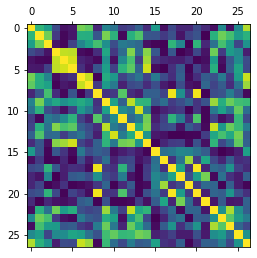

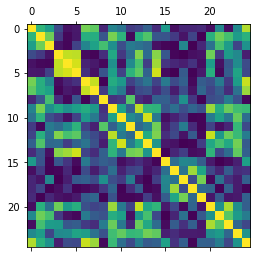

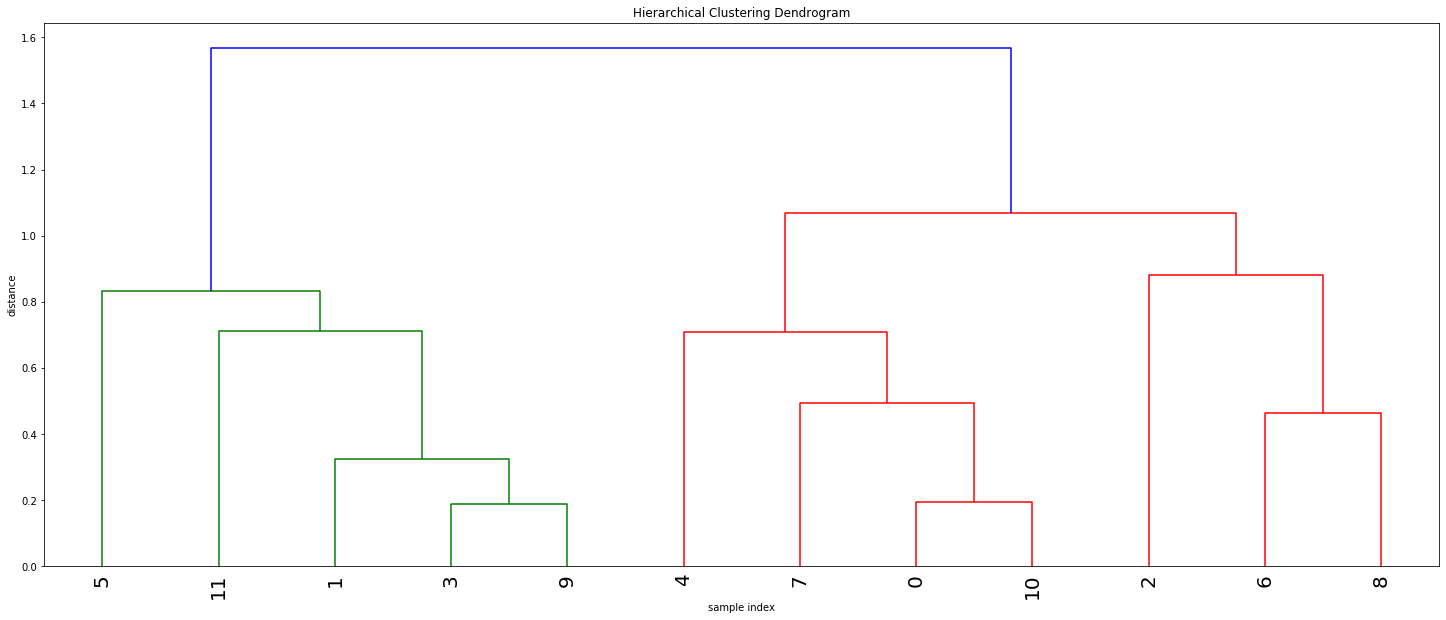

Plotting two clusters...
[2 1 2 1 2 1 2 2 2 1 2 1]


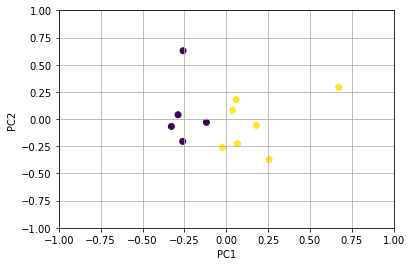

Cluster 2 has number of entries: 7
Cluster 1 has number of entries: 5
Two cluster values: [2 1 2 1 2 1 2 2 2 1 2 1]
Plotting pca for true labels...
[1 0 1 0 1 0 1 0 1 0 1 0]


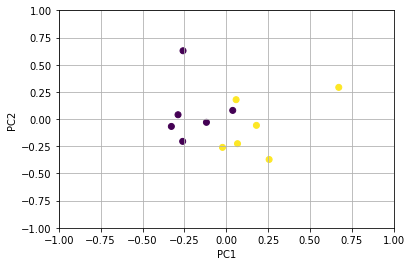

Comparing true labels: [1 0 1 0 1 0 1 0 1 0 1 0] with predicted: [1 0 1 0 1 0 1 1 1 0 1 0]
Adjusted rand score: 0.664819944598338


In [23]:
df_cluster_users_periods = compute_features(['Session ID', 'Period'])
clustering_analysis(df_cluster_users_periods, labels)

### Cluster split data

#### Drop too short splits and prepare true labels

In [24]:
# create a dataset with metadeta for splits
count_splits = Counter(df['Split'])
#print(count_splits)

df_splits_metadata = pd.DataFrame()
df_splits_metadata.insert(0, 'Period', None)
df_splits_metadata.insert(0, 'Row Count', None)
df_splits_metadata.insert(0, 'Split ID', None)
splits = df.groupby('Split')
for split_idx, split in splits:
    #print(split_count)
    #print(split)
    periods = split.groupby('Period')
    if len(periods) != 1:
        print("Split must have only one period but has {}!".format(len(periods)))
    else: 
        for name, period in periods:
            #print(name)
            #print(period)
            df_splits_metadata.loc[split_idx, 'Period'] = name
            df_splits_metadata.loc[split_idx, 'Row Count'] = count_splits[split_idx]
            df_splits_metadata.loc[split_idx, 'Split ID'] = split_idx
            
print(len(df_splits_metadata))
print(Counter(df_splits_metadata['Row Count']))
#df_splits_metadata

47
Counter({200: 37, 145: 2, 86: 1, 144: 1, 155: 1, 148: 1, 197: 1, 73: 1, 64: 1, 165: 1})


In [25]:
# shorter splits are taken for clustering if they have at least 90% of normal length
# sort out indizes of small splits
min_split = int(split_sec * 0.9)
splits_to_cluster = df_splits_metadata[df_splits_metadata['Row Count'] > min_split]
print(splits_to_cluster.index)

# set new id because when clustering 0,1,2,... indizes are taken
splits_to_cluster.insert(0, 'ID', range(0, len(splits_to_cluster)))
splits_to_cluster.set_index('ID', inplace=True)
print(len(splits_to_cluster))
print(Counter(splits_to_cluster['Row Count']))
#splits_to_cluster

Int64Index([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 16, 17, 19, 20,
            21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 34, 35, 36, 38, 39, 41, 42,
            43, 44, 45, 46],
           dtype='int64')
38
Counter({200: 37, 197: 1})


In [26]:
df_cluster_splits = compute_features(['Split'])

['Abs Diff Pitch', 'Abs Diff Yaw', 'Abs Diff Roll']
['Pitch', 'Yaw', 'Roll']


In [27]:
# sort out small splits before clustering
#print(splits_to_cluster)
splits_to_cluster_list = list(splits_to_cluster['Split ID'].values)
print(splits_to_cluster_list)

df_cluster_splits = df_cluster_splits.take(splits_to_cluster_list)
print(len(df_cluster_splits))
#df_cluster

[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 34, 35, 36, 38, 39, 41, 42, 43, 44, 45, 46]
38


In [28]:
# set true labels, convert orientation and freelook to 0 and 1
split_labels = pd.get_dummies(splits_to_cluster['Period'])

#### Perform clustering and comparison with true labels

Number of features: 30
Normalizing features...
Dropping features with 0s only...
Number of features: 30
Searching for highly correlated features...
['Sum Abs Diff Pitch', 'Sum Abs Diff Yaw', 'Sum Abs Diff Roll', 'Sum Pitch', 'Sum Yaw', 'Sum Roll']
Dropping highly correlated features: ['Sum Abs Diff Pitch', 'Sum Abs Diff Yaw', 'Sum Abs Diff Roll', 'Sum Pitch', 'Sum Yaw', 'Sum Roll']
Number of features: 24
Plotting dendogram...


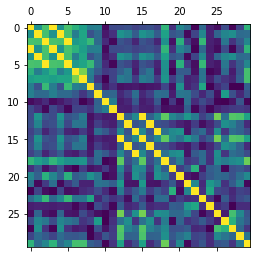

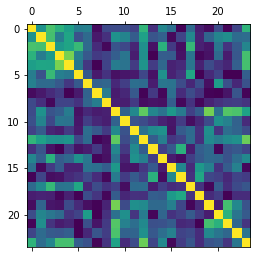

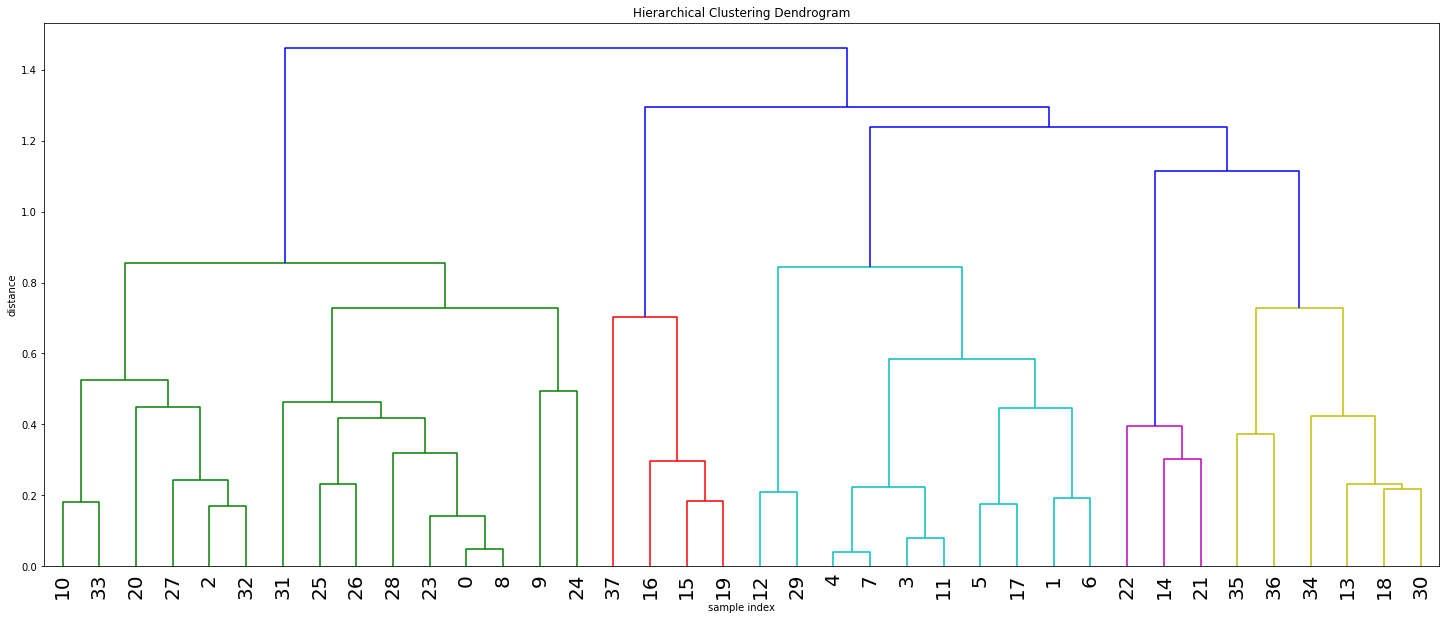

Plotting two clusters...
[1 2 1 2 2 2 2 2 1 1 1 2 2 2 2 2 2 2 2 2 1 2 2 1 1 1 1 1 1 2 2 1 1 1 2 2 2
 2]


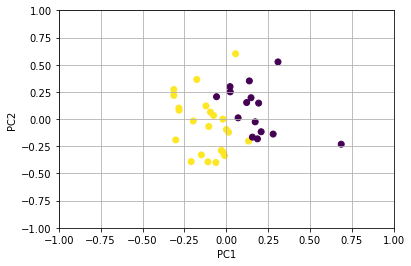

Cluster 1 has number of entries: 15
Cluster 2 has number of entries: 23
Two cluster values: [1 2 1 2 2 2 2 2 1 1 1 2 2 2 2 2 2 2 2 2 1 2 2 1 1 1 1 1 1 2 2 1 1 1 2 2 2
 2]
Plotting pca for true labels...
[0 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1
 1]


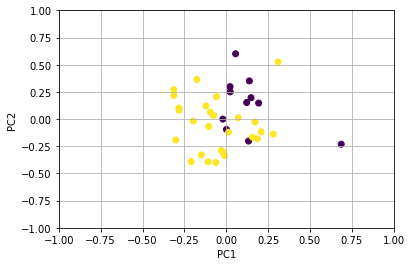

Comparing true labels: [0 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1
 1] with predicted: [0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1
 1]
Adjusted rand score: 0.10982321141576974


In [29]:
clustering_analysis(df_cluster_splits, split_labels.values.argmax(1))

In [30]:
# look at https://stats.stackexchange.com/questions/195446/choosing-the-right-linkage-method-for-hierarchical-clustering
#https://stats.stackexchange.com/questions/195456/how-to-select-a-clustering-method-how-to-validate-a-cluster-solution-to-warran/195481#195481